### 1.0 Libraries and Directories

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import curve_fit

os.chdir("/Users/jmaze/Documents/geog590/")

#Read claims data
claims_v2 = pd.read_csv('./project_data/claims_v2.csv')

### 2.0 Model RIs for total storm damages

In [2]:
storms = claims_v2[claims_v2['hazard_broad'] == 'GeneralStorm'].copy()
#storms = claims_v2.copy()

storms.loc[:, 'property_dmg'] = storms['PropertyDmg(ADJ)'] / 1e6 

storms_years = storms.groupby('Year').agg(
    total_annual_dmg=('property_dmg', 'sum')
).reset_index()

storms_years['rank'] = storms_years['total_annual_dmg'].rank(ascending=False).astype(int)

# Calculate the Return Period = (n+1/m)
def calc_ri(dataframe, year_col, damage_col):
    df = dataframe.copy()
    
    # Rank the years based on the damage column in descending order
    df['rank'] = df[damage_col].rank(ascending=False).astype(int)
    
    # Calculate the number of years in the record
    record_yrs = df[year_col].max() - df[year_col].min()

    # Define the function to calculate Return Interval (RI)
    def ri_calc(row):
        rank = row['rank']
        ri = (record_yrs + 1) / rank
        return ri

    # Apply the function to each row
    df['RI'] = df.apply(ri_calc, axis=1)
    
    return df

    
storms_years = calc_ri(storms_years, 'Year', 'total_annual_dmg')

modeling_domain = np.linspace(1, 100, num=1000)

def log_func(x, a, b):
    return a * np.log(x) + b


def ri_model_fitting(df, ri_col, dmg_col):
    
    model = curve_fit(log_func, df[ri_col], df[dmg_col])
    params = model[0]
    covariance = model[1]

    a_fit, b_fit = params
    
    model_dmg = log_func(modeling_domain, params[0], params[1])
    
    return model_dmg

curve = ri_model_fitting(storms_years, 'RI', 'total_annual_dmg')

### 2.1 Visualize RI total damages model

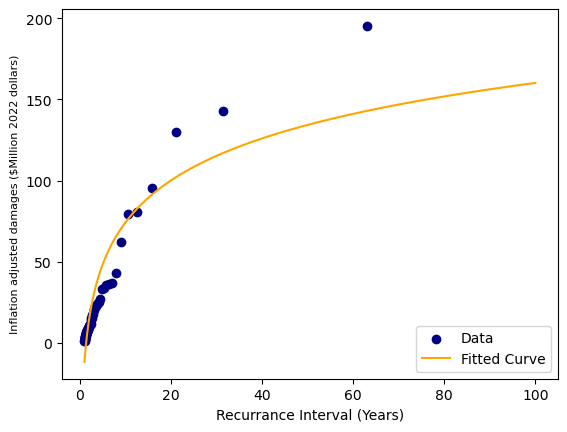

In [3]:
plt.scatter(storms_years['RI'], storms_years['total_annual_dmg'], label='Data', color='navy')

# Plot the fitted log curve
plt.plot(modeling_domain, curve, label='Fitted Curve', color='orange')
plt.xlabel('Recurrance Interval (Years)')
plt.ylabel('Inflation adjusted damages ($Million 2022 dollars)', size = 8)
plt.legend(loc='lower right')
plt.show()

### Explore the residuals for total annual storm damages

In [ ]:
plt.figure(figsize=(8, 10))
# Residuals are really bizare for low RI storms
df_temp = storms_years[storms_years['RI'] > 1.5]
plt.scatter(df_temp['RI'], df_temp['residual'], color='red', edgecolors='black')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlim(0, 100)
plt.xlabel('Recurrence Interval (Years)', size=16)
plt.ylabel('Log of Residuals', size=16)
plt.show()


### 3.0 Model the RI for Per Capita Storm Damages

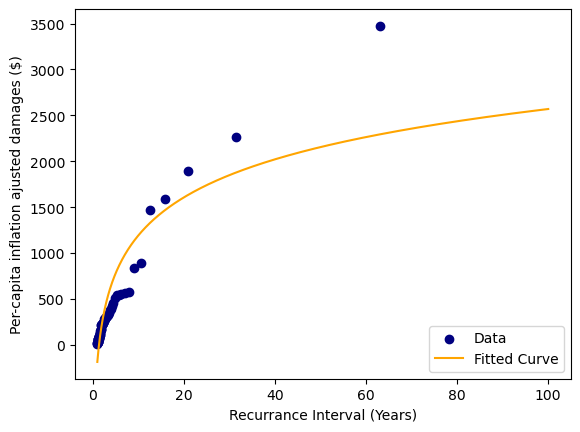

In [4]:
storms_years_percap = storms.groupby('Year').agg(
    annual_dmg_percap=('PropertyDmgPerCapita', 'sum')
).reset_index()

storms_years_percap = calc_ri(storms_years_percap, 'Year', 'annual_dmg_percap')

curve = ri_model_fitting(storms_years_percap, 'RI', 'annual_dmg_percap')

plt.scatter(storms_years_percap['RI'], storms_years_percap['annual_dmg_percap'], label='Data', color='navy')
plt.plot(modeling_domain, curve, label='Fitted Curve', color='orange')
plt.xlabel('Recurrance Interval (Years)')
plt.ylabel('Per-capita inflation ajusted damages ($)')
plt.legend(loc='lower right')


### 4.0 Evaluate if inflation adjusted per-capita damages change over time.

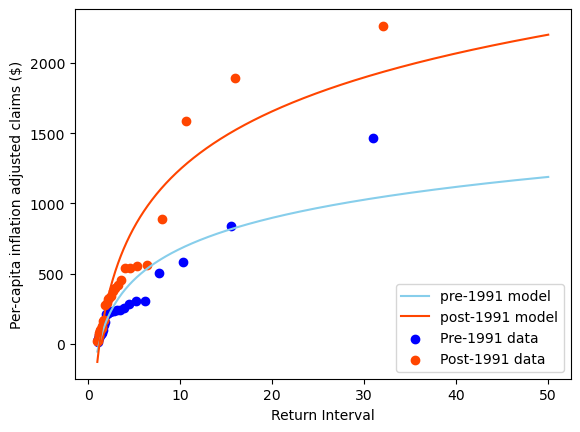

In [5]:
modeling_domain = np.linspace(1, 50, num=1000)

early = storms_years_percap[storms_years_percap['Year'] < 1991]
early = early[early['Year'] != 1984]
early = calc_ri(early, 'Year', 'annual_dmg_percap')
curve_early = ri_model_fitting(early, 'RI', 'annual_dmg_percap')

late = storms_years_percap[storms_years_percap['Year'] >= 1991]
late = calc_ri(late, 'Year', 'annual_dmg_percap')
curve_late = ri_model_fitting(late, 'RI', 'annual_dmg_percap')

plt.plot(modeling_domain, curve_early, label='pre-1991 model', color ='skyblue')
plt.plot(modeling_domain, curve_late, label='post-1991 model', color='orangered')
plt.scatter(early['RI'], early['annual_dmg_percap'], label='Pre-1991 data', color='blue')
plt.scatter(late['RI'], late['annual_dmg_percap'], label='Post-1991 data', color='orangered')
plt.xlabel('Return Interval')
plt.ylabel('Per-capita inflation adjusted claims ($)')
plt.legend(loc='lower right')

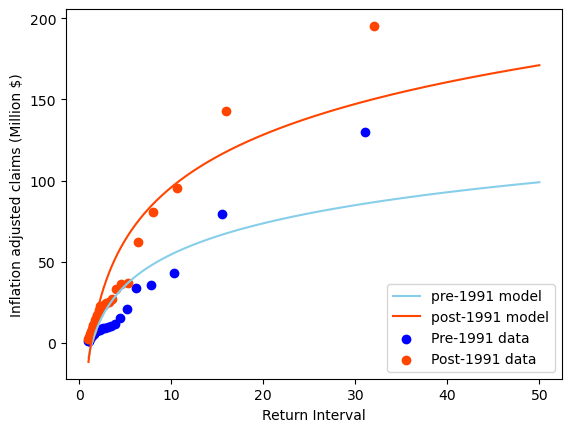

In [6]:
modeling_domain = np.linspace(1, 50, num=1000)

early = storms_years[storms_years['Year'] < 1991]
#early = early[early['Year'] != 1984]
early = calc_ri(early, 'Year', 'total_annual_dmg')
curve_early = ri_model_fitting(early, 'RI', 'total_annual_dmg')

late = storms_years[storms_years['Year'] >= 1991]
late = calc_ri(late, 'Year', 'total_annual_dmg')
curve_late = ri_model_fitting(late, 'RI', 'total_annual_dmg')

plt.plot(modeling_domain, curve_early, label='pre-1991 model', color ='skyblue')
plt.plot(modeling_domain, curve_late, label='post-1991 model', color='orangered')
plt.scatter(early['RI'], early['total_annual_dmg'], label='Pre-1991 data', color='blue')
plt.scatter(late['RI'], late['total_annual_dmg'], label='Post-1991 data', color='orangered')
plt.xlabel('Return Interval')
plt.ylabel('Inflation adjusted claims (Million $)')
plt.legend(loc='lower right')



In [7]:
function_late = {'ri': modeling_domain, 'dmg_mag': curve_late}
function_late = pd.DataFrame(function_late)

thresholds = [25, 50, 100]


    

In [8]:
print(function_late)

            ri     dmg_mag
0     1.000000  -11.700539
1     1.049049   -9.463671
2     1.098098   -7.329038
3     1.147147   -5.287699
4     1.196196   -3.331842
..         ...         ...
995  49.803804  170.862877
996  49.852853  170.908861
997  49.901902  170.954799
998  49.950951  171.000693
999  50.000000  171.046541

[1000 rows x 2 columns]


In [9]:
print(params, covariance)

NameError: name 'params' is not defined